Project Checklist (To delete later)

<br>
Model [0-4 pts]<br>
-are two different models specified [1 pt]<br>
-are difference between two models explained [1 pt]<br>
-is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]<br>
-are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]<br>
<br>

<br>
Posterior analysis (model 1) [0-4 pts]<br>
-were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]<br>
-are the samples from posterior predictive distribution analyzed [1 pt]<br>
-are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)<br>
-have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]<br>
<br>
Posterior analysis (model 2) [0-4 pts]<br>
-were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]<br>
-are the samples from posterior predictive distribution analyzed [1 pt]<br>
-are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)<br>
-have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]<br>
<br>
Model comaprison [0-4 pts]<br>
-Have models been compared using information criteria [1 pt]<br>
-Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]<br>
-Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]<br>
-Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]<br>

## Data Analytics final project <br>
Authors: Piotr Pawełczak, Mateusz Pilecki

#### Project formulation <br>

-is the problem clearly stated [1 pt] <br>
-what is the point of creating model, are potential use cases defined [1 pt] <br>

#### Data import and preprocessing

Dataset comes from https://www.kaggle.com/datasets/beksultankarimov/warsaw-flat-rent-prices. <br>
In the link there is data collected by person, who lives in Warsaw and wanted to rent a flat. <br>
Source of the data is page www.otodom.pl

In [122]:
# Import libraries to handle data
import pandas as pd

In [123]:
# Load and visualizate data
raw_data = pd.read_csv('otodom_complete.csv')
raw_data.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'offer_url',
       'offer_url-href', 'location', 'net_price', 'deposit', 'area',
       'room_num', 'build_type', 'floor', 'total_floor', 'build_mat',
       'windows', 'heating', 'year_built', 'status', 'agd', 'security',
       'add_info', 'rest_info', 'offer_ID', 'next_pagination',
       'next_pagination-href', 'add_cost', 'offer_last_update', 'second_page',
       'second_page-href', 'third_page', 'third_page-href'],
      dtype='object')

In [124]:
raw_data.head()

,web-scraper-order,web-scraper-start-url,offer_url,offer_url-href,location,net_price,deposit,area,room_num,build_type,...,rest_info,offer_ID,next_pagination,next_pagination-href,add_cost,offer_last_update,second_page,second_page-href,third_page,third_page-href
0,1612265907-2487,https://www.otodom.pl/wynajem/mieszkanie/warsz...,37 m²\n \n ...,https://www.otodom.pl/pl/oferta/wynajme-od-zar...,"Warszawa, Włochy, ul. 1 Sierpnia",2 100 zł,Kaucja:2 100 zł,Powierzchnia:37 m²,Liczba pokoi:2,NaN,...,klimatyzacja,Nr oferty w Otodom: 61451923,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,NaN,Data aktualizacji: 3 dni temu,NaN,NaN,NaN,NaN
1,1612264314-1965,https://www.otodom.pl/wynajem/mieszkanie/warsz...,38 m²\n \n ...,https://www.otodom.pl/pl/oferta/2-pokoje-tanio...,"Warszawa, Mokotów, ul. Suwak 11",1 825 zł,Kaucja:3 400 zł,Powierzchnia:38 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,...,garaż/miejsce parkingowewindapom. użytkowe,Nr oferty w Otodom: 61405987,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,Czynsz - dodatkowo:350 zł,Data aktualizacji: 2 dni temu,NaN,NaN,NaN,NaN
2,1612263242-1616,https://www.otodom.pl/wynajem/mieszkanie/warsz...,57 m²\n \n ...,https://www.otodom.pl/pl/oferta/wynajme-mieszk...,"Warszawa, Bielany, ul. Kwitnąca",3 300 zł,Kaucja:3 300 zł,Powierzchnia:57 m²,Liczba pokoi:3,Rodzaj zabudowy:blok,...,balkontylko dla niepalącychoddzielna kuchnia,Nr oferty w Otodom: 61375474,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,Czynsz - dodatkowo:1 zł,Data aktualizacji: 22 dni temu,NaN,NaN,NaN,NaN
3,1612265477-2346,https://www.otodom.pl/wynajem/mieszkanie/warsz...,63 m²\n \n ...,https://www.otodom.pl/pl/oferta/zielone-zacisz...,"Warszawa, Targówek, ul. św. Wincentego",2 200 zł,NaN,Powierzchnia:63 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,...,NaN,Nr oferty w Otodom: 61439492,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,NaN,Data aktualizacji: 5 dni temu,NaN,NaN,NaN,NaN
4,1612266187-2579,https://www.otodom.pl/wynajem/mieszkanie/warsz...,65 m²\n \n ...,https://www.otodom.pl/pl/oferta/eleganckie-mie...,"Warszawa, Ochota, Stara Ochota, ul. Juliana Ur...",3 000 zł,Kaucja:3 000 zł,Powierzchnia:65 m²,Liczba pokoi:3,Rodzaj zabudowy:kamienica,...,NaN,Nr oferty w Otodom: 61455072,NaN,NaN,NaN,Data aktualizacji: 2 dni temu,NaN,NaN,NaN,NaN


Dataset contains various parameters such as offert_url, location, price netto, deposit, area, <br>
aditional features of flat (such as air conditioning, alarm system, type of building).

#### Preprocessing

In our case we want to find relation between area of flat and price. Area can be selected from column 'offer_url'. <br>
Informations about price are located in columns 'net_price' and 'add_cost'.

In [125]:
# Selecting important columns
clipped_data = raw_data[['offer_url', 'net_price', 'add_cost']]
clipped_data.head()

,offer_url,net_price,add_cost
0,37 m²\n \n ...,2 100 zł,NaN
1,38 m²\n \n ...,1 825 zł,Czynsz - dodatkowo:350 zł
2,57 m²\n \n ...,3 300 zł,Czynsz - dodatkowo:1 zł
3,63 m²\n \n ...,2 200 zł,NaN
4,65 m²\n \n ...,3 000 zł,NaN


In [126]:
# Extract area of flat
data = pd.DataFrame()
selected_area = clipped_data['offer_url'].str.split(' m', expand=True)[0]

# Convert to numeric format 
selected_area = selected_area.str.replace(',', '.').astype(float)
data['area'] = selected_area

In [127]:
# Select net_price
net_price = clipped_data['net_price'].str[:-3] # Remove currency info (PLN)
net_price = net_price.str.replace(' ', '') # Remove white spaces
net_price = net_price.str.replace(',', '.').astype(float) # Convert to float type
data['net_price'] = net_price

# Select additional cosst
add_cost = clipped_data['add_cost'].str.split(':', expand=True)[1] # Select part with cost info
add_cost = add_cost.str[:-3] # Remove currency info (PLN)
add_cost = add_cost.str.replace(' ', '') # Remove white spaces
add_cost = add_cost.str.replace(',', '.').astype(float) # Convert to float type

data['add_cost'] = add_cost


In result we get data with following structure

In [128]:
data.head()

,area,net_price,add_cost
0,37.0,2100.0,NaN
1,38.0,1825.0,350.0
2,57.0,3300.0,1.0
3,63.0,2200.0,NaN
4,65.0,3000.0,NaN


Information about data

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3482 entries, 0 to 3481
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area       3482 non-null   float64
 1   net_price  3481 non-null   float64
 2   add_cost   1915 non-null   float64
dtypes: float64(3)
memory usage: 81.7 KB


To clean data, rows with NaN in net_price will be deleted and NaN in add_cost will be replaced with 0

In [130]:
data = data[pd.notnull(data['net_price'])]
data['add_cost'] = data['add_cost'].fillna(0)

In [131]:
# Convert data to integers
data['area'] = data['area'].astype(int)
data['net_price'] = data['net_price'].astype(int)
data['add_cost'] = data['add_cost'].astype(int)

# Calculate total price
data['total_price'] = data['net_price'] + data['add_cost']

# Save data to csv
data.to_csv('cleaned_data.csv')

In [132]:
# Filter data to reasonable values
# data = data[data['area'] <= 100]
# data = data[data['total_price'] <= 7500]


In [133]:
data.head()

,area,net_price,add_cost,total_price
0,37,2100,0,2100
1,38,1825,350,2175
2,57,3300,1,3301
3,63,2200,0,2200
4,65,3000,0,3000


# Priors

Priors [0-4 pts]<br>
-Is it explained why particular priors for parameters were selected [1 pt]<br>
-How prior parameters were selected [1 pt]<br>

https://www.otodom.pl/pl/oferty/wynajem/mieszkanie/warszawa?by=PRICE&direction=ASC&page=1

In [134]:
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
from DA_tools.DA_colors import *
from DA_tools.DA_tools import ribbon_plot

TODO: Describe ceneteing, predictor itd.

In [135]:
data['c_area'] = data.area - data.area.mean()

In [136]:
data.head()

,area,net_price,add_cost,total_price,c_area
0,37,2100,0,2100,-8.841138
1,38,1825,350,2175,-7.841138
2,57,3300,1,3301,11.158862
3,63,2200,0,2200,17.158862
4,65,3000,0,3000,19.158862


TODO: Data for simulation / Prior Predictive Check

In [137]:
N = 50
area = np.linspace(data.c_area.min(), data.c_area.max(), N)
data_sim = {'N': N, 'area': area}

TODO: Compile and sample

In [138]:
model_ppc = CmdStanModel(stan_file='linear_regression_ppc.stan')

R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=1)

alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')
price_sim = sim.stan_variable('price')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


-Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]<br>

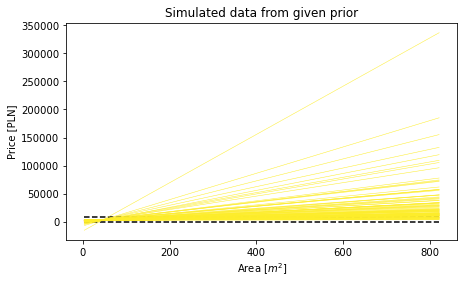

In [139]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,8000],xmin=data.area.min(),xmax=data.area.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(data.area,alpha_sim[i]+beta_sim[i]*data.c_area,color=MID,alpha=0.5,linewidth=0.5)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title(r'Simulated data from given prior')
plt.show()

-Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]<br>


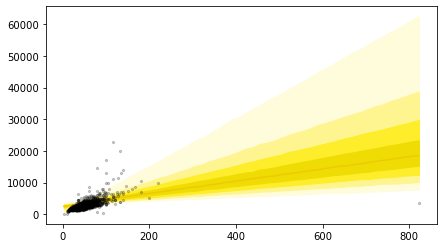

In [140]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(data_sim['area'] + data.area.mean(), price_sim, axes)
axes.scatter(data.area,data.total_price,color='black',alpha=0.2,s=5)
plt.show()


# Posterior

In [157]:
model_fit = CmdStanModel(stan_file="linear_regression_fit.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [158]:
d_short=data.head(1000)

data_fit = {
    "N": len(d_short),
    "area": d_short.c_area.values,
    "price": d_short.total_price.values
}

fit = model_fit.sample(data=data_fit,seed=1)
alpha_fit = fit.stan_variable('alpha')
beta_fit = fit.stan_variable('beta')
mu_fit = fit.stan_variable('mu')
price_pred = fit.stan_variable('price_pred')
az.summary(fit, var_names=['mu'], kind='stats', hdi_prob=.95)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)











chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:03 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:03 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:04 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:04 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:04 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:05 Iteration: 1900 / 2000 [ 95%]  (Sampling)



chain 1 |██████████| 00:05 Sampling completed                       
chain 2 |██████████| 00:05 Sampling completed                       
chain 3 |██████████| 00:05 Sampling completed                       
chain 4 |██████████| 00:05 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_2.5%,hdi_97.5%
mu[0],2191.852,33.860,2125.67,2258.28
mu[1],2243.123,33.231,2176.96,2306.74
mu[2],3217.276,34.322,3149.89,3282.43
mu[3],3524.903,39.332,3446.25,3600.15
mu[4],3627.445,41.315,3544.54,3706.60
...,...,...,...,...
mu[995],1422.784,48.302,1328.55,1520.61
mu[996],2448.208,31.328,2387.23,2508.18
mu[997],2448.208,31.328,2387.23,2508.18
mu[998],1627.868,43.764,1543.82,1717.30


In [143]:
import arviz as az
az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,2645.15,30.54,2589.64,2703.59
beta,51.27,1.52,48.50,54.14
sigma,955.10,21.36,916.27,995.94


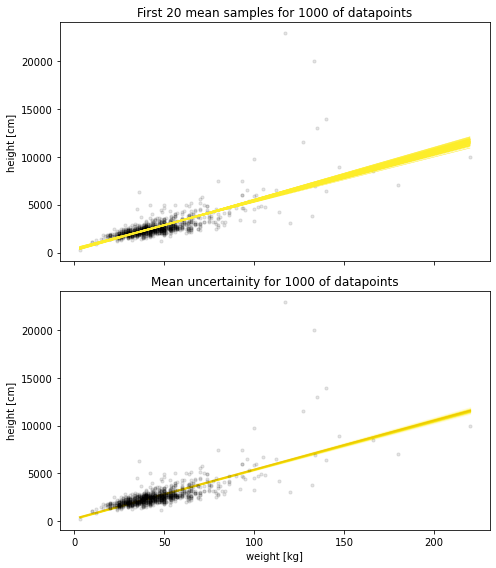

In [144]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes[0]
for i in range(100):
    ax0.plot(d_short.area,
              alpha_fit[i]+beta_fit[i]*d_short.c_area,
              color=MID,
              alpha=0.5,linewidth=0.5)
ax0.scatter(d_short.area,d_short.total_price,color='black',alpha=0.1,s=10)
ax0.set_ylabel('height [cm]')
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short)))
ax1=axes[1]
ax1=ribbon_plot(d_short.area.values,mu_fit,ax1,supress_warning=True)
ax1.scatter(d_short.area,d_short.total_price,color='black',alpha=0.1,s=10)
ax1.set_xlabel('weight [kg]')
ax1.set_ylabel('height [cm]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short)))
fig.tight_layout()
plt.show()

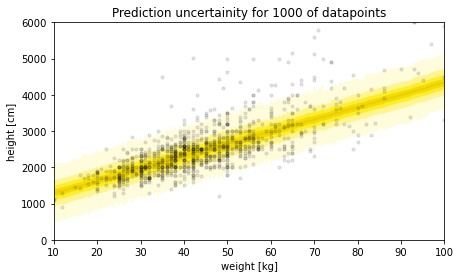

In [151]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.area.values, price_pred,axes,supress_warning=True)
axes.scatter(d_short.area, d_short.total_price,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.xlim([10, 100])
plt.ylim([0, 6000])
plt.show()

Student (debil)

In [153]:
model_fit = CmdStanModel(stan_file="student_ppc.stan")

INFO:cmdstanpy:compiling stan file C:\Users\piotr\Desktop\ISZ\Semestr 1\data_analytics_2022\Project\student_ppc.stan to exe file C:\Users\piotr\Desktop\ISZ\Semestr 1\data_analytics_2022\Project\student_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\Users\piotr\Desktop\ISZ\Semestr 1\data_analytics_2022\Project\student_ppc.exe


In [154]:
data = pd.read_csv('cleaned_data.csv')
data['c_area'] = data.area - data.area.mean()
d_short=data.head(1000)

data_fit = {
    "N": len(d_short),
    "area": d_short.c_area.values,
    "price": d_short.total_price.values
}

fit = model_fit.sample(data=data_fit,seed=1)
alpha_fit = fit.stan_variable('alpha')
beta_fit = fit.stan_variable('beta')
mu_fit = fit.stan_variable('mu')
price_pred = fit.stan_variable('price_pred')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)











chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:06 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:07 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:08 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:08 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:09 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:10 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:10 Iteration: 1900 / 2000 [ 95%]  (Sampling)



INFO:cmdstanpy:CmdStan done processing.


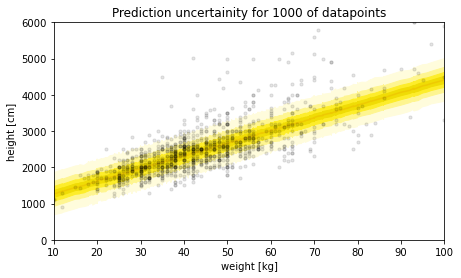

In [155]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.area.values, price_pred,axes,supress_warning=True)
axes.scatter(d_short.area, d_short.total_price,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.xlim([10, 100])
plt.ylim([0, 6000])
plt.show()

In [156]:
az.summary(fit, var_names=['mu'], kind='stats', hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%
mu[0],2209.148,13.946,2181.21,2235.67
mu[1],2244.097,13.696,2218.16,2271.75
mu[2],2908.131,20.669,2864.64,2946.09
mu[3],3117.826,25.483,3068.01,3168.54
mu[4],3187.725,27.186,3133.61,3240.74
...,...,...,...,...
mu[995],1684.910,23.082,1639.43,1729.54
mu[996],2383.894,13.394,2357.46,2409.53
mu[997],2383.894,13.394,2357.46,2409.53
mu[998],1824.707,19.990,1786.42,1864.34
